In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import os

%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau



sns.set(style='white', context='notebook', palette='deep')

Train size: (36000, 785)
Test size: (9000, 785)


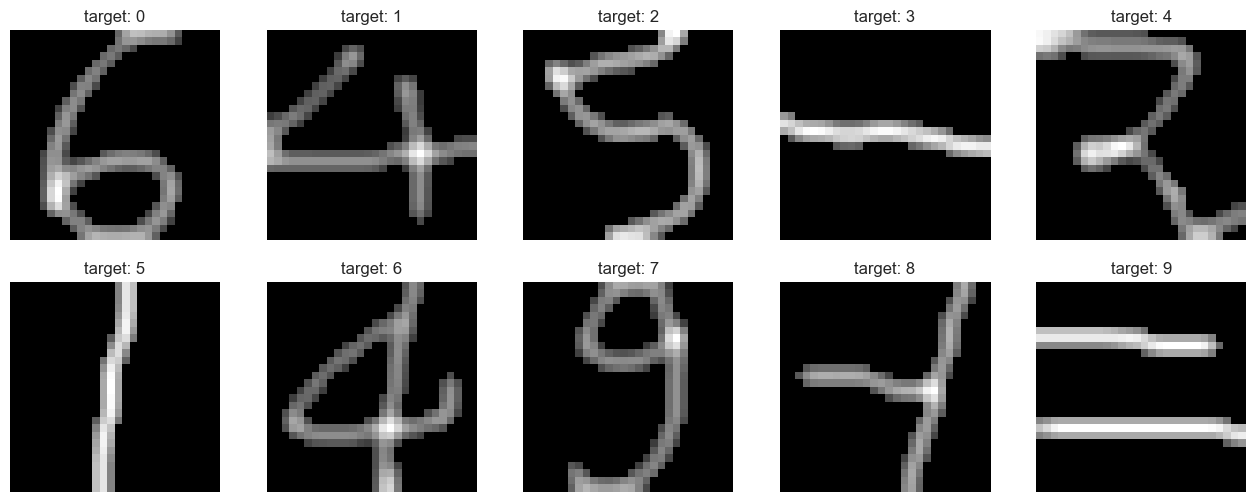

In [2]:
folder_path = '../dataset'
test_folder_path = "../test_img"

# Load the data
train_df = pd.read_csv("{}/train.csv".format(folder_path))
test_df = pd.read_csv("{}/test.csv".format(folder_path))

print("Train size:",train_df.shape)
print("Test size:",test_df.shape)

examples = 10

# Create a directory to save the examples images
if os.path.exists(test_folder_path):
    shutil.rmtree(test_folder_path)
os.makedirs(test_folder_path, exist_ok = True)

# Reshape the data into a 28x28 grid
img_list= []
for i in range(examples):
    df = train_df.iloc[i,1:]
    img = df.values.reshape(28, 28).astype(np.uint8)
    img_list.append(img)
    
    cv2.imwrite('{}/test_{}.jpg'.format(test_folder_path, i), img)


fig, axes = plt.subplots(examples//5, 5, figsize=(16, 6))
for i in range(examples):
    axes[i//5, i %5].imshow(img_list[i], cmap='gray')
    axes[i//5, i %5].axis('off')
    axes[i//5, i %5].set_title(f"target: {i}")
    
plt.show()


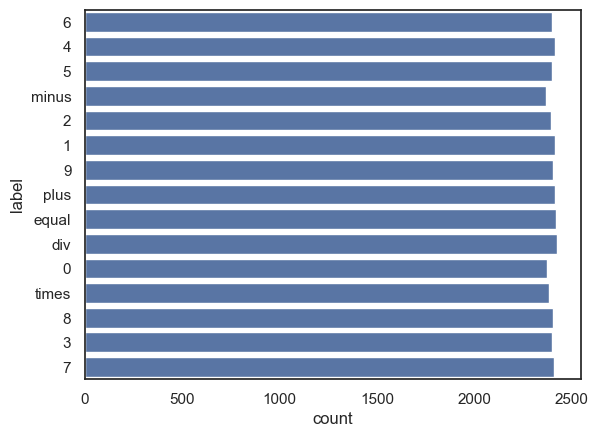

In [3]:
Y_train = train_df["label"]

# Drop 'label' column
X_train = train_df.drop(labels = ["label"],axis = 1) 
test = test_df.drop(labels = ["label"],axis = 1)

# free some space
del train_df 

g = sns.countplot(y = Y_train)


2. Check for null and missing values

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

3. Normalization

In [6]:
# Normalization
X_train = X_train /255
test = test /255


In [7]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Label Encoding and One-Hot Encoding

In [ ]:
Y_str = list(map(str, Y_train)) 

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y_str)

print("Danh sách các nhãn sau khi mã hóa:")
for i, label in enumerate(encoder.classes_):
    print(f"{label}  →  {i}")

Y_train = Y_encoded


Danh sách các nhãn sau khi mã hóa:
0  →  0
1  →  1
2  →  2
3  →  3
4  →  4
5  →  5
6  →  6
7  →  7
8  →  8
9  →  9
div  →  10
equal  →  11
minus  →  12
plus  →  13
times  →  14


In [9]:
# Label encoding
Y_train = to_categorical(Y_train, num_classes=15)

In [10]:
# Set the random seed
random_seed = 2

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state= random_seed)
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(32400, 28, 28, 1) (3600, 28, 28, 1)
(32400, 15) (3600, 15)


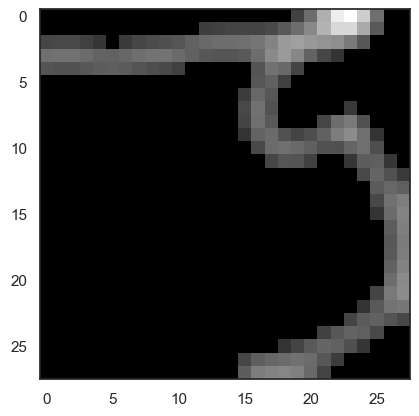

In [11]:
# Test example
g = plt.imshow(X_train[0][:,:,0], cmap = 'gray')

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten(input_shape=(28,28)))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation = "softmax"))

c:\Users\Acer\Desktop\Project_of_me\Handwritten_ML\Handwritten_ML\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Acer\Desktop\Project_of_me\Handwritten_ML\Handwritten_ML\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = RMSprop(learning_rate= 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

c:\Users\Acer\Desktop\Project_of_me\Handwritten_ML\Handwritten_ML\env\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30 
batch_size = 128

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [16]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30


c:\Users\Acer\Desktop\Project_of_me\Handwritten_ML\Handwritten_ML\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 - 29s - 114ms/step - accuracy: 0.7771 - loss: 0.7381 - val_accuracy: 0.9742 - val_loss: 0.0999 - learning_rate: 1.0000e-03
Epoch 2/30


c:\Users\Acer\Desktop\Project_of_me\Handwritten_ML\Handwritten_ML\env\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\Acer\Desktop\Project_of_me\Handwritten_ML\Handwritten_ML\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


253/253 - 1s - 4ms/step - accuracy: 0.9297 - loss: 0.2587 - val_accuracy: 0.9767 - val_loss: 0.0823 - learning_rate: 1.0000e-03
Epoch 3/30
253/253 - 28s - 110ms/step - accuracy: 0.9256 - loss: 0.2611 - val_accuracy: 0.9864 - val_loss: 0.0500 - learning_rate: 1.0000e-03
Epoch 4/30
253/253 - 1s - 5ms/step - accuracy: 0.9375 - loss: 0.1927 - val_accuracy: 0.9842 - val_loss: 0.0553 - learning_rate: 1.0000e-03
Epoch 5/30
253/253 - 27s - 105ms/step - accuracy: 0.9461 - loss: 0.1858 - val_accuracy: 0.9878 - val_loss: 0.0437 - learning_rate: 1.0000e-03
Epoch 6/30
253/253 - 1s - 4ms/step - accuracy: 0.9766 - loss: 0.0797 - val_accuracy: 0.9867 - val_loss: 0.0452 - learning_rate: 1.0000e-03
Epoch 7/30
253/253 - 25s - 98ms/step - accuracy: 0.9593 - loss: 0.1493 - val_accuracy: 0.9881 - val_loss: 0.0396 - learning_rate: 1.0000e-03
Epoch 8/30
253/253 - 1s - 4ms/step - accuracy: 0.9453 - loss: 0.2670 - val_accuracy: 0.9914 - val_loss: 0.0334 - learning_rate: 1.0000e-03
Epoch 9/30
253/253 - 24s - 95m

In [17]:
if not os.path.exists('../model'):
    os.makedirs('../model', exist_ok = True)

# Save the model
model.save('../model/model.keras')

In [18]:
history.history.keys()
print(history.history['accuracy'])
print(len(history.history['accuracy'])) 

[0.7771132588386536, 0.9296875, 0.9256011247634888, 0.9375, 0.946145236492157, 0.9765625, 0.9592525959014893, 0.9453125, 0.9627850651741028, 0.953125, 0.9683316946029663, 0.984375, 0.9707795977592468, 0.9765625, 0.973754346370697, 0.9609375, 0.9761713147163391, 0.984375, 0.9768840074539185, 0.9609375, 0.977751612663269, 0.9765625, 0.9784952998161316, 0.9609375, 0.98054039478302, 0.9609375, 0.9793629050254822, 0.984375, 0.9807572960853577, 0.9765625]
30


4. Evaluate the model

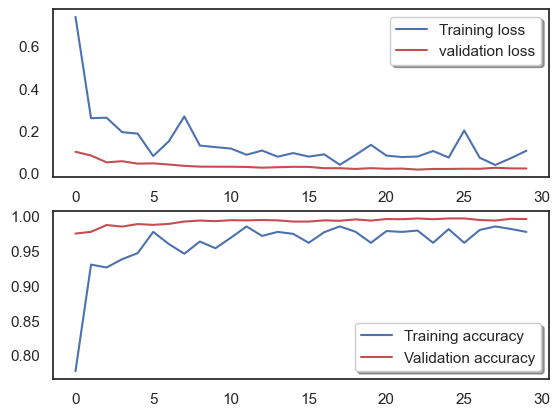

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

4. Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


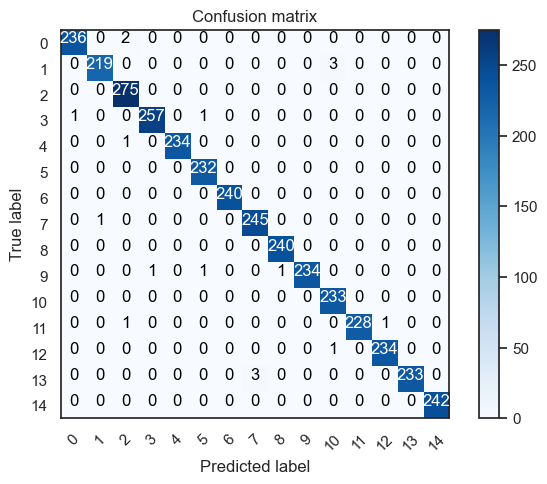

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(15)) 

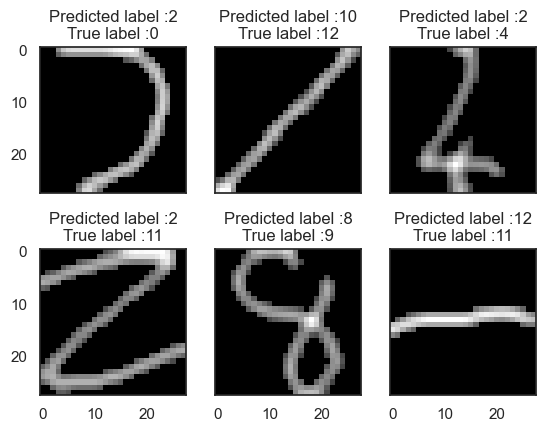

In [21]:
# Display some error results 
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Convert to one hot vectors

In [22]:
test_labels = test_df["label"]

test_str = list(map(str, test_labels))  

# encoder đã được khai báo ở trên
test_encoded = encoder.fit_transform(test_str)

print("Danh sách các nhãn sau khi mã hóa:")
for i, label in enumerate(encoder.classes_):
    print(f"{label}  →  {i}")

true_labels = test_encoded

Danh sách các nhãn sau khi mã hóa:
0  →  0
1  →  1
2  →  2
3  →  3
4  →  4
5  →  5
6  →  6
7  →  7
8  →  8
9  →  9
div  →  10
equal  →  11
minus  →  12
plus  →  13
times  →  14


Predictions

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy:  0.9931111111111111  =>  99.31 %


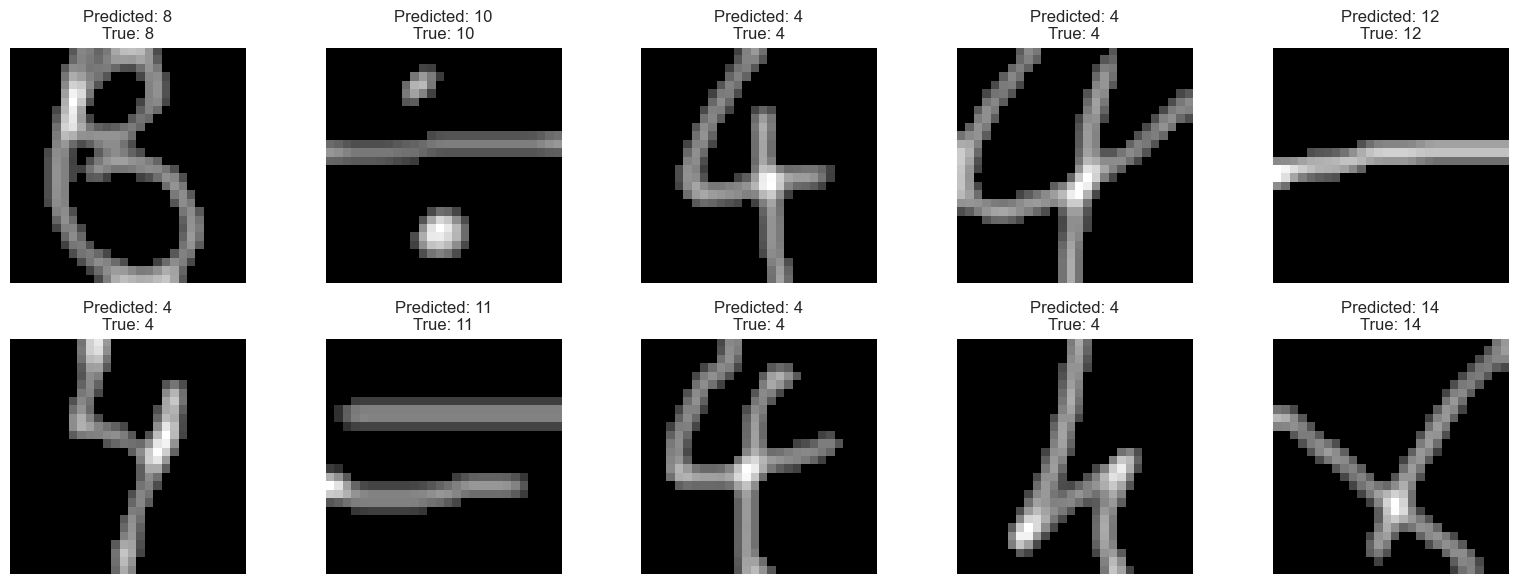

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

# Show some images of the results
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(test[i].reshape(28, 28), cmap="gray")
    axes[i].set_title("Predicted: {}".format(results[i])  + "\n" + 
                      "True: {}".format(true_labels[i]))
    axes[i].axis("off")

print("Accuracy: ", np.sum(results == true_labels) / len(true_labels), " => ", round((np.sum(results == true_labels) / len(true_labels))*100, 2), "%")
plt.tight_layout()
plt.show()
